In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.frameon'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['legend.framealpha'] = 0

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load data
twist = np.load('predictions/TwistMutants.npz')
toll = np.load('predictions/TollMutants.npz')
spz = np.load('predictions/SpzMutants.npz')
wt = np.load('predictions/WTComparison.npz')

# Plotting functions
from morphogenesis.plot_utils import plot_tensor, ap_min, ap_max, dv_min, dv_max, dv_midpoint
from scipy.interpolate import RectBivariateSpline as interp2d
from math import floor, ceil
def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

def trajectory_plot(ax, v0, v1, nDV=8, nAP=8, hh=0.2, s=3):
    '''
    Plot trajectories of cells in test flow field
    '''
    DV = np.linspace(dv_min + 25, dv_max - 25, nDV)
    AP = np.linspace(ap_min + 25, ap_max - 25, nAP)
    pts = np.stack(np.meshgrid(AP, DV, indexing='xy'), axis=-1).reshape([-1, 2])

    DV = np.linspace(dv_min, dv_max, 236)
    AP = np.linspace(ap_min, ap_max, 200)
    
    y0Paths = rk4DynamicVelocity2D(pts, AP, DV, v0, hh)
    y1Paths = rk4DynamicVelocity2D(pts, AP, DV, v1, hh)
    
    nPts = y0Paths.shape[0]
    nTps = y0Paths.shape[1]
    for tpId in range(nTps - 1):
        ax.scatter(y0Paths[:, tpId, 0], y0Paths[:, tpId, 1], s=s,
                   c=np.ones(nPts) * tpId,
                   cmap='Blues', vmin=-10, vmax=nTps*1.2)
        ax.scatter(y1Paths[:, tpId, 0], y1Paths[:, tpId, 1], s=s,
                   c=np.ones(nPts) * tpId,
                   cmap='Reds', vmin=-10, vmax=nTps*1.2)
    
    ax.set(xlim=[ap_min, ap_max], xticks=[ap_min, ap_max], xticklabels=['A', 'P'])
    ax.set(ylim=[dv_min, dv_max], yticks=[dv_min, dv_midpoint, dv_max], yticklabels=['V', 'D', 'V'])
    ax.set_aspect('equal')

    return y0Paths, y1Paths

def mean_deviation(paths0, paths1):
    dist = np.linalg.norm(paths0-paths1, axis=-1)
    return np.mean(dist)

def get_cut(z, N0=50, N1=150):
    '''
    Return the average DV cut between N0 and N1 along the AP axis
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)

    return cut

    # Normalize by value at Ventral pole
    return cut / cut[118]


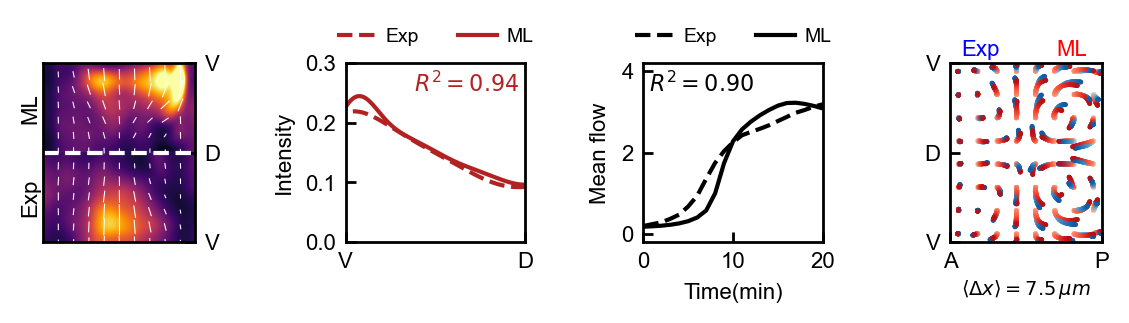

In [14]:
# For each phenotype, we plot
# 1. The myosin pattern at the end of the simulation
# 2. The traces of the myosin pattern over time
# 3. The time-course of the predicted velocity field
# 4. The integrated cell trajectories
fig, ax = plt.subplots(1, 4, dpi=200, figsize=(6, 1.5), constrained_layout=True)

data = wt

# Plot the myosin patterns
mmin, mmax = 0.05, 0.30
alpha = np.zeros([236, 200])
alpha[:118, :] = 1
plot_tensor(ax[0], data['m0'][-1] * alpha, alpha=alpha, vmin=mmin, vmax=mmax, both=False)
plot_tensor(ax[0], data['m'][-1] * (1 -alpha), alpha=(1 - alpha), vmin=mmin, vmax=mmax, both=False)
ax[0].axhline(dv_midpoint, color='white', linestyle='--')
ax[0].text(-0.02, 0.75, 'ML', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].text(-0.02, 0.25, 'Exp', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].set(ylim=[dv_min, dv_max], yticks=[dv_min, dv_midpoint, dv_max], yticklabels=['V', 'D', 'V'])
ax[0].yaxis.tick_right()

# Plot the myosin traces
from sklearn.metrics import r2_score

dv = np.linspace(dv_min, dv_max, 236)
vfc=40
cut0 = get_cut(data['m0'][-1])
cut = get_cut(data['m'][-1])
ax[1].plot(dv, cut0, label='Exp', color='firebrick', linestyle='--')
ax[1].plot(dv, cut, label='ML', color='firebrick')
ax[1].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)

ax[1].set(xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'])
ax[1].set(ylim=[0, 0.3], yticks=[0, .1, .2, .3], ylabel='Intensity')

mask = np.logical_and(dv-dv_min >= vfc, dv <= dv_midpoint)
ax[1].text(0.97, 0.96, f'$R^2={r2_score(cut0[mask], cut[mask]):.2f}$', 
           color='firebrick',
           ha='right', va='top', transform=ax[1].transAxes)
ax[1].set_aspect((dv_midpoint-dv_min-vfc) / 0.3)

# Plot the velocity traces
vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
ax[2].plot(data['t'], v0norm, label='Exp', color='black', linestyle='--')
ax[2].plot(data['t'], vnorm, label='ML', color='black')
ax[2].text(0.03, 0.96, f'$R^2={r2_score(v0norm, vnorm):.2f}$', 
           color='black',
           ha='left', va='top', transform=ax[2].transAxes)

ax[2].set(xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time(min)')
ax[2].set(ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow')
ax[2].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)
ax[2].set_aspect(20/4.4)

# Plot the cell trajectories
paths0, paths1 = trajectory_plot(
    ax[3], data['v0'], data['v'], 
    nDV=8, nAP=8, hh=0.2, s=0.5)
ax[3].text(0.2, 1.02, 'Exp', color='Blue', va='bottom', ha='center', transform=ax[3].transAxes)
ax[3].text(0.8, 1.02, 'ML', color='Red', va='bottom', ha='center', transform=ax[3].transAxes)

ax[3].text(0.5, -0.2, f'$\\langle \\Delta x \\rangle = {mean_deviation(paths0[:, -2], paths1[:, -2]):.2g}\, \\mu m$',
           fontsize=7, ha='center', va='top', transform=ax[3].transAxes)

plt.savefig('figures/WT.svg', bbox_inches='tight')

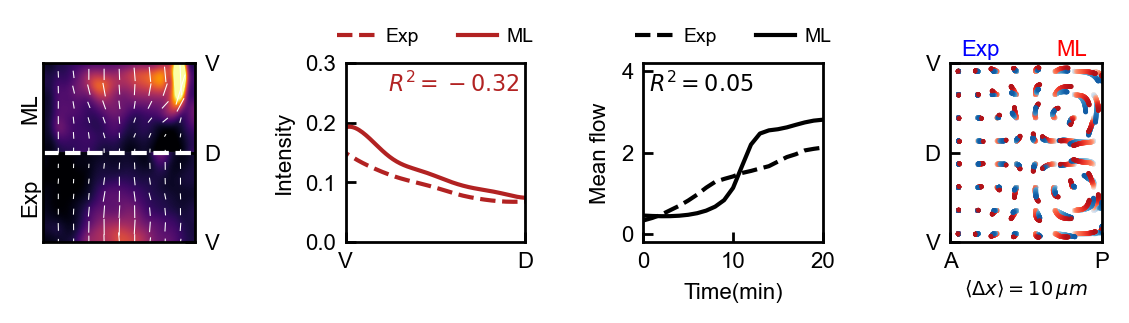

In [15]:
# For each phenotype, we plot
# 1. The myosin pattern at the end of the simulation
# 2. The traces of the myosin pattern over time
# 3. The time-course of the predicted velocity field
# 4. The integrated cell trajectories
fig, ax = plt.subplots(1, 4, dpi=200, figsize=(6, 1.5), constrained_layout=True)

data = twist

# Plot the myosin patterns
mmin, mmax = 0.05, 0.30
alpha = np.zeros([236, 200])
alpha[:118, :] = 1
plot_tensor(ax[0], data['m0'][-1] * alpha, alpha=alpha, vmin=mmin, vmax=mmax, both=False)
plot_tensor(ax[0], data['m'][-1] * (1 -alpha), alpha=(1 - alpha), vmin=mmin, vmax=mmax, both=False)
ax[0].axhline(dv_midpoint, color='white', linestyle='--')
ax[0].text(-0.02, 0.75, 'ML', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].text(-0.02, 0.25, 'Exp', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].set(ylim=[dv_min, dv_max], yticks=[dv_min, dv_midpoint, dv_max], yticklabels=['V', 'D', 'V'])
ax[0].yaxis.tick_right()

# Plot the myosin traces
from sklearn.metrics import r2_score

dv = np.linspace(dv_min, dv_max, 236)
vfc=40
cut0 = get_cut(data['m0'][-1])
cut = get_cut(data['m'][-1])
ax[1].plot(dv, cut0, label='Exp', color='firebrick', linestyle='--')
ax[1].plot(dv, cut, label='ML', color='firebrick')
ax[1].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)

ax[1].set(xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'])
ax[1].set(ylim=[0, 0.3], yticks=[0, .1, .2, .3], ylabel='Intensity')

mask = np.logical_and(dv-dv_min >= vfc, dv <= dv_midpoint)
ax[1].text(0.97, 0.96, f'$R^2={r2_score(cut0[mask], cut[mask]):.2f}$', 
           color='firebrick',
           ha='right', va='top', transform=ax[1].transAxes)
ax[1].set_aspect((dv_midpoint-dv_min-vfc) / 0.3)

# Plot the velocity traces
vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
ax[2].plot(data['t'], v0norm, label='Exp', color='black', linestyle='--')
ax[2].plot(data['t'], vnorm, label='ML', color='black')
ax[2].text(0.03, 0.96, f'$R^2={r2_score(v0norm, vnorm):.2f}$', 
           color='black',
           ha='left', va='top', transform=ax[2].transAxes)

ax[2].set(xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time(min)')
ax[2].set(ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow')
ax[2].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)
ax[2].set_aspect(20/4.4)

# Plot the cell trajectories
paths0, paths1 = trajectory_plot(
    ax[3], data['v0'], data['v'], 
    nDV=8, nAP=8, hh=0.2, s=0.5)
ax[3].text(0.2, 1.02, 'Exp', color='Blue', va='bottom', ha='center', transform=ax[3].transAxes)
ax[3].text(0.8, 1.02, 'ML', color='Red', va='bottom', ha='center', transform=ax[3].transAxes)

ax[3].text(0.5, -0.2, f'$\\langle \\Delta x \\rangle = {mean_deviation(paths0[:, -2], paths1[:, -2]):.2g}\, \\mu m$',
           fontsize=7, ha='center', va='top', transform=ax[3].transAxes)

plt.savefig('figures/Twist.svg', bbox_inches='tight')

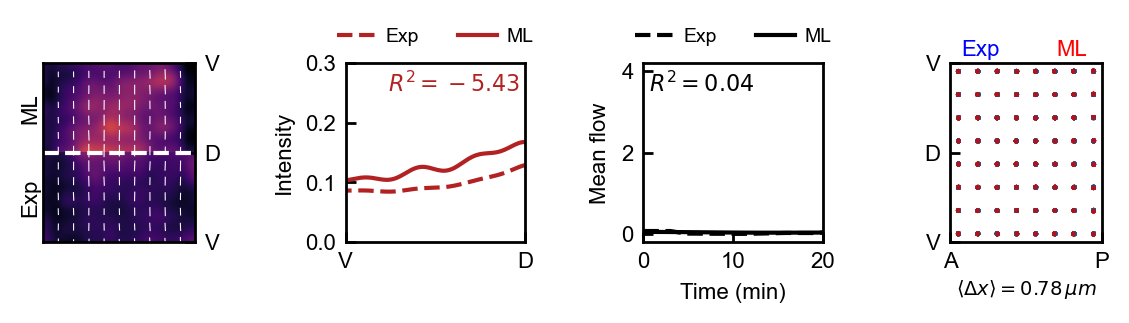

In [16]:
# For each phenotype, we plot
# 1. The myosin pattern at the end of the simulation
# 2. The traces of the myosin pattern over time
# 3. The time-course of the predicted velocity field
# 4. The integrated cell trajectories
fig, ax = plt.subplots(1, 4, dpi=200, figsize=(6, 1.5), constrained_layout=True)

data = toll

# Plot the myosin patterns
mmin, mmax = 0.05, 0.30
alpha = np.zeros([236, 200])
alpha[:118, :] = 1
plot_tensor(ax[0], data['m0'][-1] * alpha, alpha=alpha, vmin=mmin, vmax=mmax, both=False)
plot_tensor(ax[0], data['m'][-1] * (1 -alpha), alpha=(1 - alpha), vmin=mmin, vmax=mmax, both=False)
ax[0].axhline(dv_midpoint, color='white', linestyle='--')
ax[0].text(-0.02, 0.75, 'ML', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].text(-0.02, 0.25, 'Exp', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].set(ylim=[dv_min, dv_max], yticks=[dv_min, dv_midpoint, dv_max], yticklabels=['V', 'D', 'V'])
ax[0].yaxis.tick_right()

# Plot the myosin traces
from sklearn.metrics import r2_score

dv = np.linspace(dv_min, dv_max, 236)
vfc=40
cut0 = get_cut(data['m0'][-1])
cut = get_cut(data['m'][-1])
ax[1].plot(dv, cut0, label='Exp', color='firebrick', linestyle='--')
ax[1].plot(dv, cut, label='ML', color='firebrick')
ax[1].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)

ax[1].set(xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'])
ax[1].set(ylim=[0, 0.3], yticks=[0, .1, .2, .3], ylabel='Intensity')

mask = np.logical_and(dv-dv_min >= vfc, dv <= dv_midpoint)
ax[1].text(0.97, 0.96, f'$R^2={r2_score(cut0[mask], cut[mask]):.2f}$', 
           color='firebrick',
           ha='right', va='top', transform=ax[1].transAxes)
ax[1].set_aspect((dv_midpoint-dv_min-vfc) / 0.3)

# Plot the velocity traces
vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
ax[2].plot(data['t'], v0norm, label='Exp', color='black', linestyle='--')
ax[2].plot(data['t'], vnorm, label='ML', color='black')
ax[2].text(0.03, 0.96, f'$R^2={r2_score(v0norm, vnorm):.2f}$', 
           color='black',
           ha='left', va='top', transform=ax[2].transAxes)

ax[2].set(xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time (min)')
ax[2].set(ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow')
ax[2].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)
ax[2].set_aspect(20/4.4)

# Plot the cell trajectories
paths0, paths1 = trajectory_plot(
    ax[3], data['v0'], data['v'], 
    nDV=8, nAP=8, hh=0.2, s=0.5)
ax[3].text(0.2, 1.02, 'Exp', color='Blue', va='bottom', ha='center', transform=ax[3].transAxes)
ax[3].text(0.8, 1.02, 'ML', color='Red', va='bottom', ha='center', transform=ax[3].transAxes)

ax[3].text(0.5, -0.2, f'$\\langle \\Delta x \\rangle = {mean_deviation(paths0[:, -2], paths1[:, -2]):.2g}\, \\mu m$',
           fontsize=7, ha='center', va='top', transform=ax[3].transAxes)

plt.savefig('figures/Toll.svg', bbox_inches='tight')

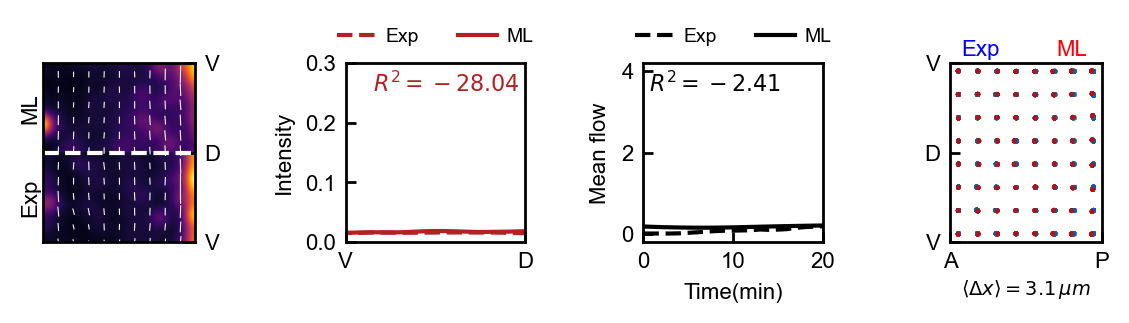

In [17]:
# For each phenotype, we plot
# 1. The myosin pattern at the end of the simulation
# 2. The traces of the myosin pattern over time
# 3. The time-course of the predicted velocity field
# 4. The integrated cell trajectories
fig, ax = plt.subplots(1, 4, dpi=200, figsize=(6, 1.5), constrained_layout=True)

data = spz

# Plot the myosin patterns
mmin, mmax = 0.01, 0.07
alpha = np.zeros([236, 200])
alpha[:118, :] = 1
plot_tensor(ax[0], data['m0'][-1] * alpha, alpha=alpha, vmin=mmin, vmax=mmax, both=False)
plot_tensor(ax[0], data['m'][-1] * (1 -alpha), alpha=(1 - alpha), vmin=mmin, vmax=mmax, both=False)
ax[0].axhline(dv_midpoint, color='white', linestyle='--')
ax[0].text(-0.02, 0.75, 'ML', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].text(-0.02, 0.25, 'Exp', rotation=90, va='center', ha='right', transform=ax[0].transAxes)
ax[0].set(ylim=[dv_min, dv_max], yticks=[dv_min, dv_midpoint, dv_max], yticklabels=['V', 'D', 'V'])
ax[0].yaxis.tick_right()

# Plot the myosin traces
from sklearn.metrics import r2_score

dv = np.linspace(dv_min, dv_max, 236)
vfc=40
cut0 = get_cut(data['m0'][-1])
cut = get_cut(data['m'][-1])
ax[1].plot(dv, cut0, label='Exp', color='firebrick', linestyle='--')
ax[1].plot(dv, cut, label='ML', color='firebrick')
ax[1].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)

ax[1].set(xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'])
ax[1].set(ylim=[0, 0.3], yticks=[0, .1, .2, .3], ylabel='Intensity')

mask = np.logical_and(dv-dv_min >= vfc, dv <= dv_midpoint)
ax[1].text(0.97, 0.96, f'$R^2={r2_score(cut0[mask], cut[mask]):.2f}$', 
           color='firebrick',
           ha='right', va='top', transform=ax[1].transAxes)
ax[1].set_aspect((dv_midpoint-dv_min-vfc) / 0.3)

# Plot the velocity traces
vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
ax[2].plot(data['t'], v0norm, label='Exp', color='black', linestyle='--')
ax[2].plot(data['t'], vnorm, label='ML', color='black')
ax[2].text(0.03, 0.96, f'$R^2={r2_score(v0norm, vnorm):.2f}$', 
           color='black',
           ha='left', va='top', transform=ax[2].transAxes)

ax[2].set(xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time(min)')
ax[2].set(ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow')
ax[2].legend(framealpha=0., loc='lower center', 
             fontsize=7, handlelength=2, handletextpad=0.5,
             bbox_to_anchor=[0.5, 1.0], ncol=2)
ax[2].set_aspect(20/4.4)

# Plot the cell trajectories
paths0, paths1 = trajectory_plot(
    ax[3], data['v0'], data['v'], 
    nDV=8, nAP=8, hh=0.2, s=0.5)
ax[3].text(0.2, 1.02, 'Exp', color='Blue', va='bottom', ha='center', transform=ax[3].transAxes)
ax[3].text(0.8, 1.02, 'ML', color='Red', va='bottom', ha='center', transform=ax[3].transAxes)

ax[3].text(0.5, -0.2, f'$\\langle \\Delta x \\rangle = {mean_deviation(paths0[:, -2], paths1[:, -2]):.2g}\, \\mu m$',
           fontsize=7, ha='center', va='top', transform=ax[3].transAxes)

plt.savefig('figures/Spz.svg', bbox_inches='tight')

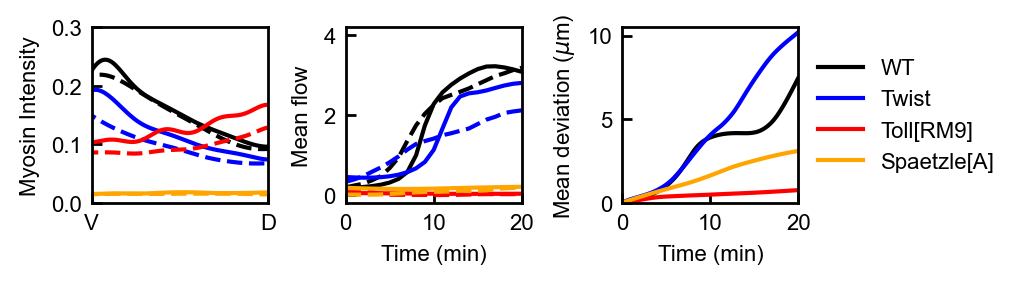

In [18]:
# Plot traces over time

nDV, nAP = 8, 8
DV = np.linspace(dv_min + 25, dv_max - 25, nDV)
AP = np.linspace(ap_min + 25, ap_max - 25, nAP)
pts = np.stack(np.meshgrid(AP, DV, indexing='xy'), axis=-1).reshape([-1, 2])

DV = np.linspace(dv_min, dv_max, 236)
AP = np.linspace(ap_min, ap_max, 200)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(5.0, 1.5), constrained_layout=True)

colors = ['black', 'blue', 'red', 'orange']
labels = ['WT', 'Twist', 'Toll[RM9]', 'Spaetzle[A]']
for data, color, label in zip([wt, twist, toll, spz], colors, labels):
    cut0 = get_cut(data['m0'][-1])
    cut = get_cut(data['m'][-1])
    ax[0].plot(dv, cut0, label='Exp', color=color, linestyle='--')
    ax[0].plot(dv, cut, label='ML', color=color)

    vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
    v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
    ax[1].plot(data['t'], v0norm, label='Exp', color=color, linestyle='--')
    ax[1].plot(data['t'], vnorm, label='ML', color=color)
    
    y0Paths = rk4DynamicVelocity2D(pts, AP, DV, data['v0'], hh=0.2)[:, :-1]
    y1Paths = rk4DynamicVelocity2D(pts, AP, DV, data['v'], hh=0.2)[:, :-1]

    tt = np.linspace(data['t'][0], data['t'][-1], y0Paths.shape[1])
    traj_diff = np.linalg.norm(y0Paths-y1Paths, axis=-1).mean(axis=0)
    ax[2].plot(tt, traj_diff, color=color, label=label)

# Axis formatting
ax[0].set(
    xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'],
    ylim=[0, 0.3], yticks=[0, 0.1, 0.2, 0.3], ylabel='Myosin Intensity',
    aspect=(dv_midpoint-dv_min-vfc) / 0.3,
)
ax[1].set(
    xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time (min)',
    ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow',
    aspect=20/4.4,
)
ax[2].set(
    xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time (min)',
    ylim=[0, 10.5], yticks=[0, 5, 10], ylabel='Mean deviation ($\mu$m)',
    aspect=20/10.5,
)
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/Traces.svg', bbox_inches='tight')

In [242]:
ap_max-ap_min

452.471